In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.5f}'.format)

DATA_DIRECTORY = "data/objects/raw"

In [2]:
# Reading the parquet files
def read_parquet_files(DATA_DIRECTORY):
    list_of_df = []
    for root, _, files in os.walk(DATA_DIRECTORY):
        for file in files:
            if file.endswith('.parquet'):
                file_path = os.path.join(root, file)
                df = pd.read_parquet(file_path,engine='pyarrow')
                list_of_df.append(df)
    combined_df = pd.concat(list_of_df)
    return combined_df
data = read_parquet_files(DATA_DIRECTORY)

In [3]:
# check data types and info
display(data.info())

# check nan 
display(data.isna().sum())
print("""There is {n_nan} nans in the dataset""".format(n_nan=data.isna().sum().sum()))

# total number of objects without any cleaning or processing at the intersection
print("""Without any cleaning or processing, the total number of objects at the intersection between 11am and 1pm on Monday 14 Octobre 2024 is: {nb_objects} """.
      format(nb_objects = data["id"].nunique()))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16647945 entries, 0 to 2416224
Data columns (total 17 columns):
 #   Column      Dtype         
---  ------      -----         
 0   timestamp   datetime64[ns]
 1   id          int32         
 2   label       category      
 3   tracking    category      
 4   confidence  float16       
 5   pos_x       float16       
 6   pos_y       float16       
 7   pos_z       float16       
 8   size_x      float16       
 9   size_y      float16       
 10  size_z      float16       
 11  vel_x       float16       
 12  vel_y       float16       
 13  vel_z       float16       
 14  yaw         float16       
 15  yaw_rate    float16       
 16  points_n    int16         
dtypes: category(2), datetime64[ns](1), float16(12), int16(1), int32(1)
memory usage: 762.1 MB


None

timestamp     0
id            0
label         0
tracking      0
confidence    0
pos_x         0
pos_y         0
pos_z         0
size_x        0
size_y        0
size_z        0
vel_x         0
vel_y         0
vel_z         0
yaw           0
yaw_rate      0
points_n      0
dtype: int64

There is 0 nans in the dataset
Without any cleaning or processing, the total number of objects at the intersection between 11am and 1pm on Monday 14 Octobre 2024 is: 133885 


## Filtering on objects based on duration and speed

* We have to remove objects that do not respect a lower and an upper threshold of time stay in the intersection
they might be outlier or stationary objects. We set two thresholds: 
    1. Maximal time stay is **20 minutes** which is could be represent traffic jam (for cars). We consider that a pedestrian or a cyclist will not stay more than 20 minutes also at an intersection unless there is a bus station ..
    
    2. Minimum time stay is around **10 seconds** which corresponds to the duration that a car will take to pass 140 m  at 50km/h (which is the maximal speed authorized in urban areas). The replay shows that 10 second is an acceptable threshold to set the minimum time of stay an object in the intersection.


* We want have to remove objects whose **maximal detected speed is less than 1 m/s** which corresponds to a regular speed of human being when walking which is the minimal speed an object can have on the road in our situation. The velocity is calculated using this formula: 

                            velocity = √(vel_x² + vel_y² + vel_z²)

In [4]:
# removing objects according to their time stay
#distance = 140 # suppose 70 m minimal distance to see a pattern ?
#velocity = 50 # suppose 60km/h in a city maximal velocity in France is 50 km/h
max_duration = 1200  # 900 seconds corresponds to car traffic jam 3 mins
min_duration = 10   #distance/ (velocity/3.6) #  
timedelta_df = data.groupby("id")["timestamp"].agg([min, max]).reset_index()
timedelta_df["timedelta"] = timedelta_df["max"] - timedelta_df["min"]
timedelta_df["timedelta_seconds"] = timedelta_df["timedelta"].dt.total_seconds()
selected_ids_time_stay = timedelta_df[(timedelta_df['timedelta_seconds'] < max_duration) &\
(timedelta_df['timedelta_seconds'] > min_duration)]["id"].values.tolist()
data = data[data["id"].isin(selected_ids_time_stay)]

# removing objects according to their speed
data["velocity"] = np.sqrt(data["vel_x"]**2 + data["vel_y"]**2 +data["vel_z"]**2)
df_velocity = data.groupby("id")["velocity"].agg([np.max]).reset_index()
df_velocity.columns=  ["id","max_velocity"]
selected_ids_speed = df_velocity[df_velocity['max_velocity'] > 1]["id"].values.tolist()
data = data[data["id"].isin(selected_ids_speed)]

# total number of objects without any cleaning or processing at the intersection
print("""After applying two filters on the data, the total number of objects at the intersection between 11am and 1pm on Monday 14 Octobre 2024 is: {nb_objects} """.
      format(nb_objects = data["id"].nunique()))

After applying two filters on the data, the total number of objects at the intersection between 11am and 1pm on Monday 14 Octobre 2024 is: 25222 


## Insights and observations on categorical variables
* **Some objects has more than one label in the dataframe**. To handle this issue, for each id, we set two rules:
    1. Get the label with the confidence level that is greater than 0.8
    2. If no label has a confidence label greater than 0.8, take the mode of the all labels of the same id



In [5]:
def unify_labels_for_same_object(df):
    try:
        # based on confidence value, > 0.8
        label = df.loc[df[df["confidence"]>0.8].index,"label"].unique()[0] 
    except:
        # based on mode
        label = df["label"].mode()[0]
    df["label"] = label
    return df

list_df_id_label= [unify_labels_for_same_object(df) for _,df in data.groupby("id")]
data = pd.concat(list_df_id_label).reset_index(drop=True)

Unique values in tracking: ['TRACKING', 'DRIFTING']


LABEL_CAR          60.60979
LABEL_PEDESTRIAN   22.44073
LABEL_MISC         13.66664
LABEL_CYCLIST       3.28285
Name: label, dtype: float64

TRACKING   93.21564
DRIFTING    6.78436
Name: tracking, dtype: float64

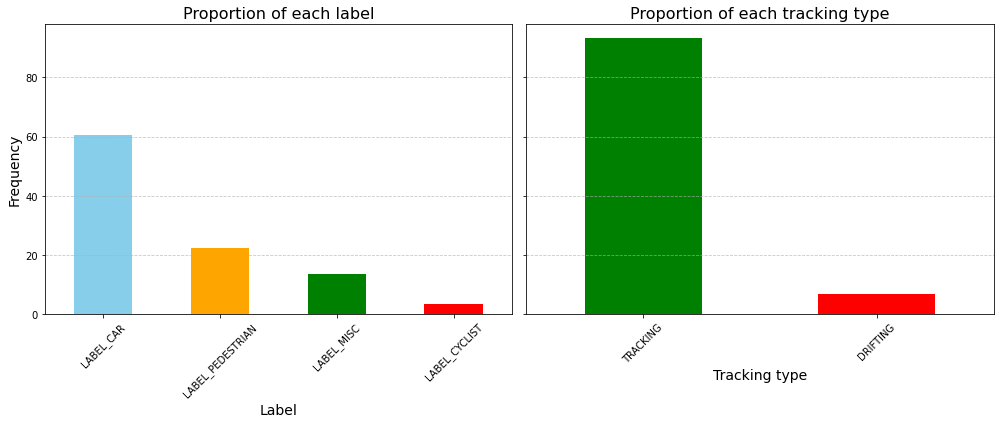

In [6]:
# checking possible values of categorical variables 
for col in data.select_dtypes(include='category'):
    print("Unique values in {col}: {values}".format(col=col, values= data[col].unique().tolist()))
    
# computing relative frequency of each possible value for label and tracking type
label_proportions = data.groupby('id')['label'].value_counts(normalize=True).index    
label_proportions = pd.DataFrame(label_proportions.values.tolist(),
                                 columns=["id","label"])["label"].value_counts(normalize=True)*100
tracking_type_proportions = data['tracking'].value_counts(normalize=True)*100
display(label_proportions)
display(tracking_type_proportions)

# creating barcharts for label and tracking
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
label_proportions.plot(kind='bar', color=['skyblue', 'orange', 'green', 'red'], ax=axes[0])
axes[0].set_title('Proportion of each label', fontsize=16)
axes[0].set_xlabel('Label', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

tracking_type_proportions.plot(kind='bar', color=['green', 'red'], ax=axes[1])
axes[1].set_title('Proportion of each tracking type', fontsize=16)
axes[1].set_xlabel('Tracking type', fontsize=14)
axes[1].set_ylabel('Frequency', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Approximately 13% of the labels correspond to unspecified objects**, which is a significant proportion. In order to estimate the label, we will construct a classifier (*RandomForestClassifier*) that predicts whether it is a car, pedestrian or cyclist based on the *size*, *velocity* and *points_n* of the object. The classifier will be trained only on observations where label is  car, pedestrian or cyclist.

**But first we have to explore numerical variables that will be used as features during model training.**

## Exploratory Data Analysis for numerical variables

In [7]:
# describe to get some stats about numerical variables
df_describe = data.describe()
numerical_columns = [col for col in df_describe.columns if col != "id"]
display(df_describe)

,id,confidence,pos_x,pos_y,pos_z,size_x,size_y,size_z,vel_x,vel_y,vel_z,yaw,yaw_rate,points_n,velocity
count,8109766.00000,8109766.00000,8109766.00000,8109766.00000,8109766.00000,8109766.00000,8109766.00000,8109766.00000,8109766.00000,8109766.00000,8109766.00000,8109766.00000,8109766.00000,8109766.00000,8109766.00000
mean,1776510.40800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,NaN,NaN,170.39343,NaN
std,160658.21540,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,319.48243,0.00000
min,1477200.00000,0.10999,-166.25000,-122.68750,0.00000,0.00000,0.00000,0.00000,-98.62500,-73.62500,0.00000,0.00000,-6.28125,0.00000,0.00000
25%,1635421.00000,0.50000,-44.00000,-32.28125,0.00000,0.66992,0.43994,0.75000,-0.97998,-0.08002,0.00000,2.70508,-0.03000,18.00000,0.03000
50%,1782065.00000,0.81982,-24.12500,-19.59375,0.00000,3.98047,1.82031,1.45020,-0.02000,-0.00000,0.00000,3.15430,0.00000,57.00000,0.33521
75%,1914671.00000,0.95020,20.89062,-5.67188,0.00000,4.55859,1.95996,1.79980,0.03000,0.03000,0.00000,4.39844,0.01000,213.00000,1.94238
max,2046920.00000,1.95996,113.06250,71.50000,3.42969,21.20312,20.95312,3.50000,45.09375,70.56250,0.00000,6.28125,6.28125,11625.00000,98.68750


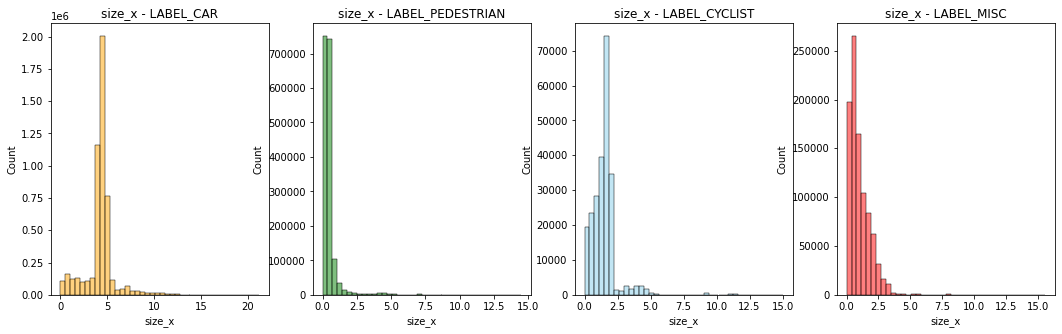

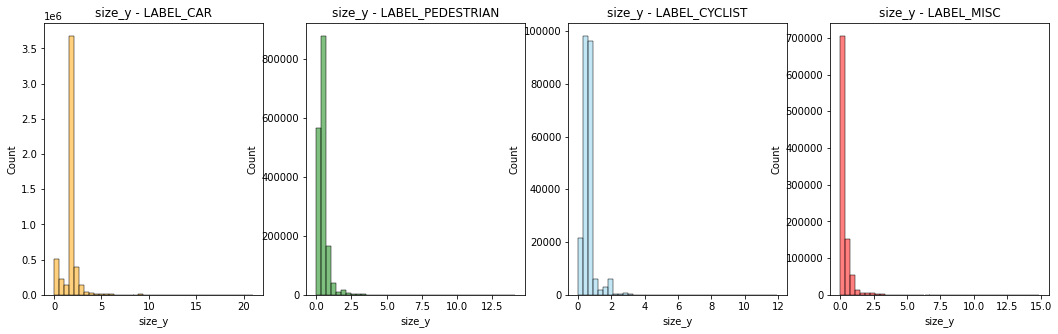

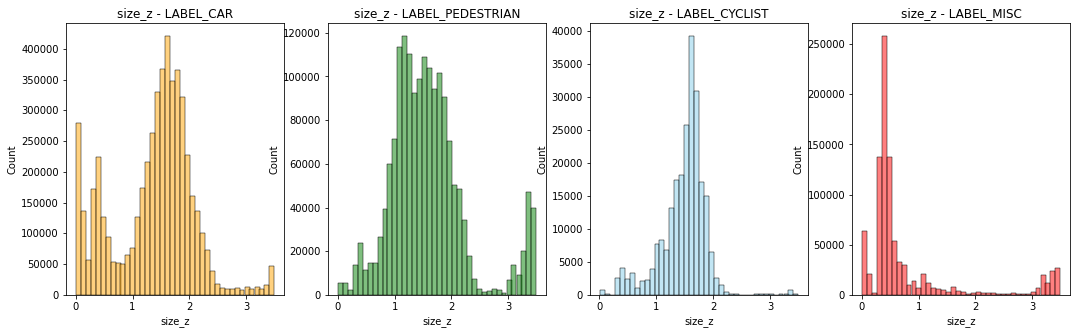

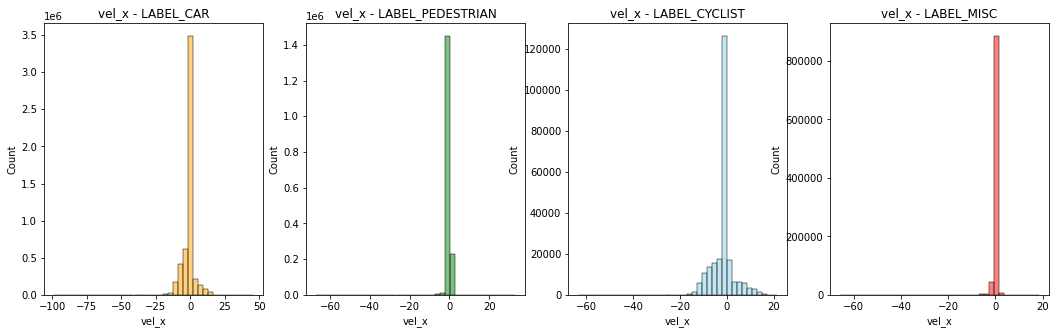

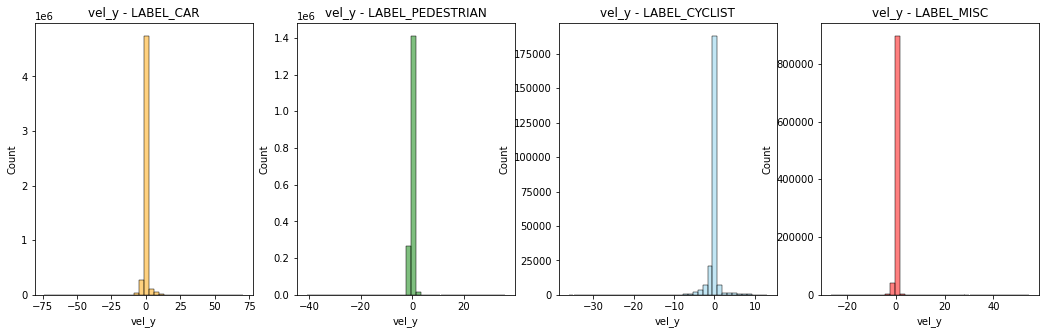

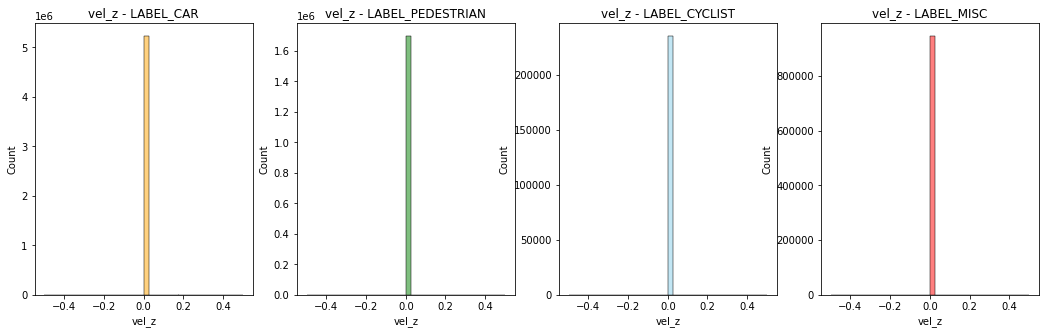

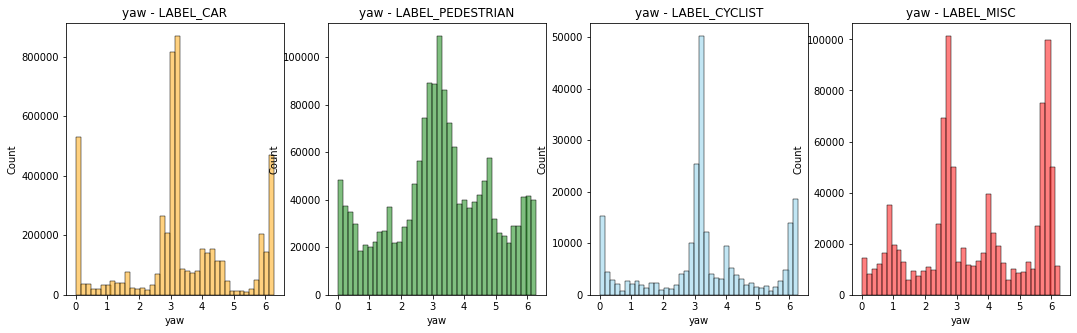

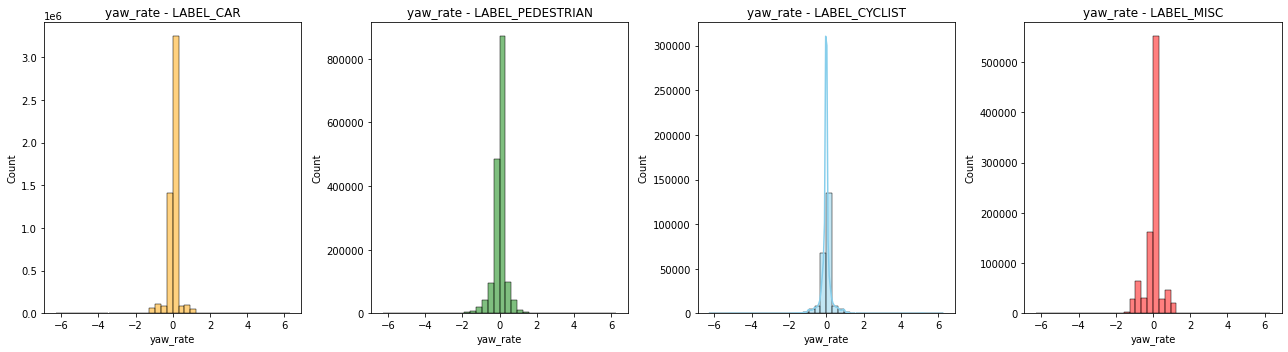

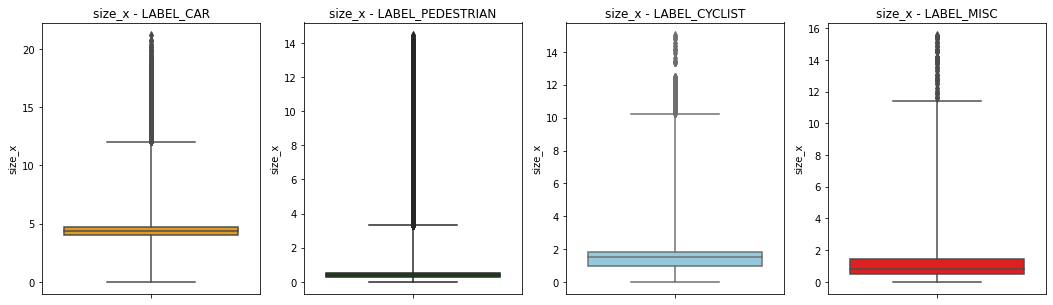

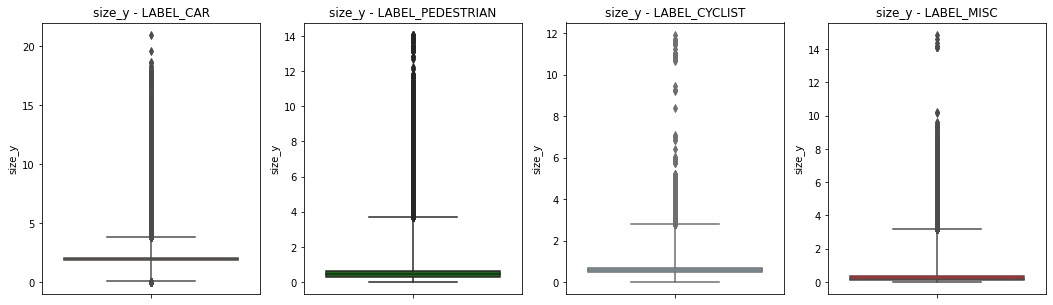

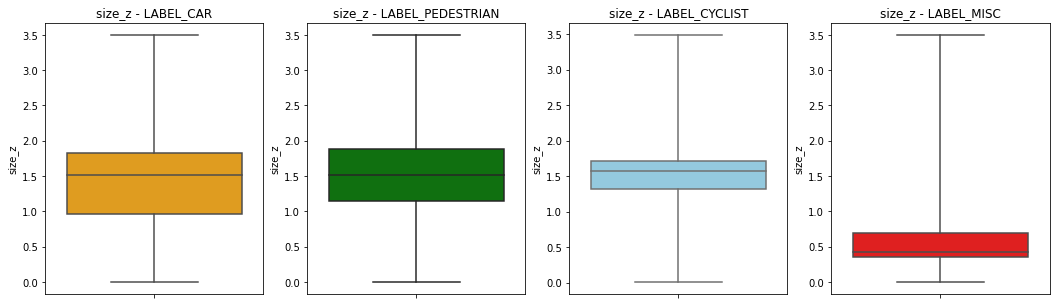

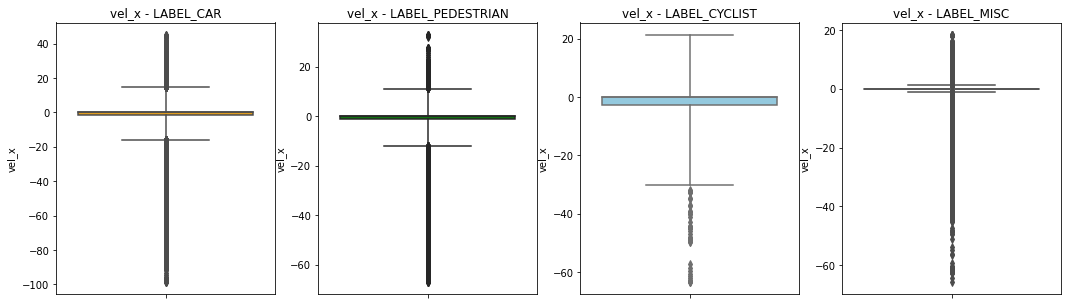

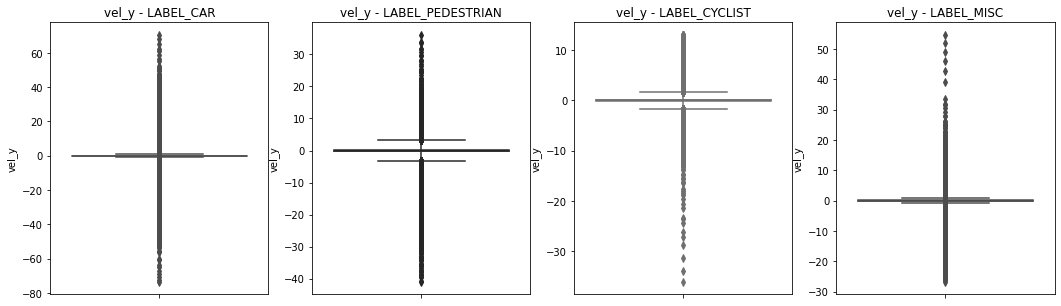

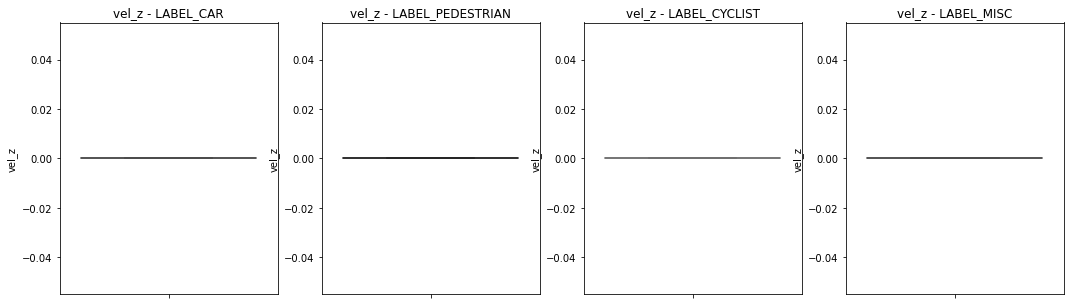

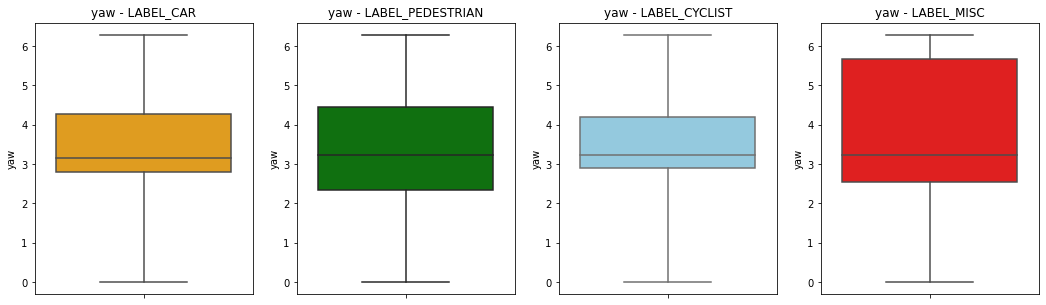

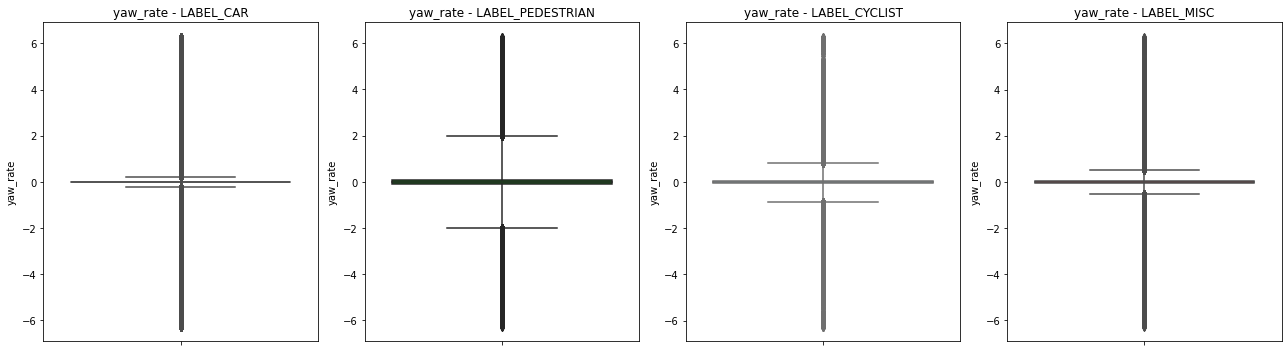

In [8]:
def plot_histograms(data,numerical_columns):
    # histogram of numerical variables for each label (cars, pedestrian, cyclist)
    possible_labels = data["label"].unique()
    colors = ['orange', 'green', 'skyblue','red']
    for i, num_col in enumerate(numerical_columns):
        fig, axes = plt.subplots(nrows=1, ncols=len(possible_labels), figsize=(18, 5))
        for j, label in enumerate(possible_labels):
            subset = data[data["label"] == label]     
            sns.histplot(subset, x=num_col, kde=True, ax=axes[j], color=colors[j], bins=40)
            axes[j].set_title("{num_col} - {label}".format(num_col=num_col,label=label))

    plt.tight_layout()
    plt.show()
    
def plot_boxplots(data,numerical_columns):
    # boxplots of numerical variables for each label (MISC, cars, pedestrian, cyclist)
    possible_labels = data["label"].unique()
    colors = ['orange', 'green', 'skyblue','red']
    for i, num_col in enumerate(numerical_columns):
        fig, axes = plt.subplots(nrows=1, ncols=len(possible_labels), figsize=(18, 5))
        for j, label in enumerate(possible_labels):
            subset = data[data["label"] == label]
            sns.boxplot(data=subset, y=num_col, ax=axes[j], color=colors[j],whis=10)
            axes[j].set_title("{num_col} - {label}".format(num_col=num_col,label=label))
    plt.tight_layout()
    plt.show()
    
    
numerical_columns = ["size_x","size_y","size_z","vel_x","vel_y","vel_z","yaw","yaw_rate"]
# hist plots and box plots
plot=True # set to false to avoid plotting when testing
if plot:
    plot_histograms(data,numerical_columns)
    plot_boxplots(data,numerical_columns)

### Insights on Numerical Variables

1. Some values of `confidence` are greater than 1. These should be capped at 1, as confidence values typically range from 0 to 1.

2. `pos_x` and `pos_y` appear to represent the coordinates of objects within the intersection. The values are both negative and positive, indicating that the objects are distributed around the origin. Some `pos_z` values are not zero.They might be outliers since the objects are expected to be on the ground.

3. Some values in `size_x`, `size_y` and `size_z` are abnormal specially for pedestrians and cyclists. If the label is correct (e.g. Pedestrian, cyclist or car) we can detect them using IQR (interquartile range) method then replace them with the median of each distribution. 

4. No specific remarks on `vel_x` and `vel_y` as they are centered around zero, which is normal for an intersection where objects runs at opposite directions. `vel_z` is always zero as expected. The unit is `m/s`. 

5. The distribution of `yaw` is expected to be like this. Values close to 0 and 6.28 correspond to 0° and 360° (the same direction), values around 3.14  correspond to the opposite direction (180° or π), and values near 1.5 and 4.71 (π/2 and 3π/2) correspond to standard turns (90° and 270°).

### Detecting and Replacing Outliers with the Median 
**Each label (car, pedestrian, cyclist) has been handled separately**

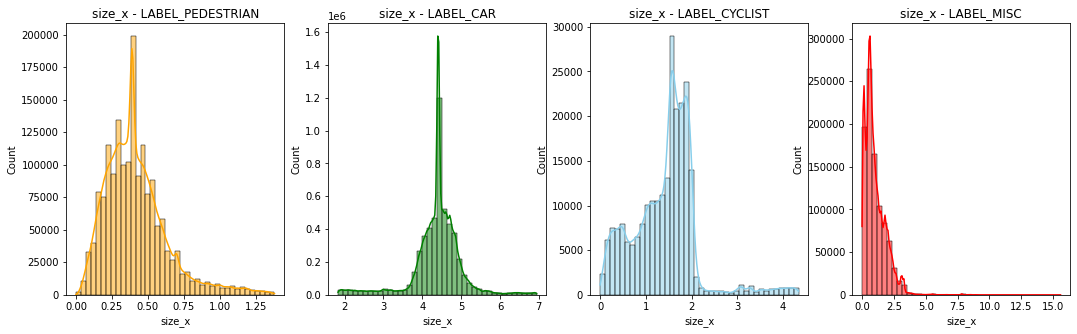

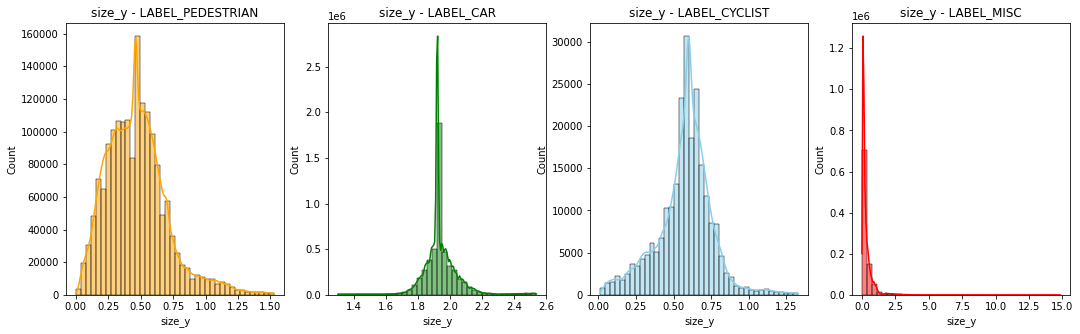

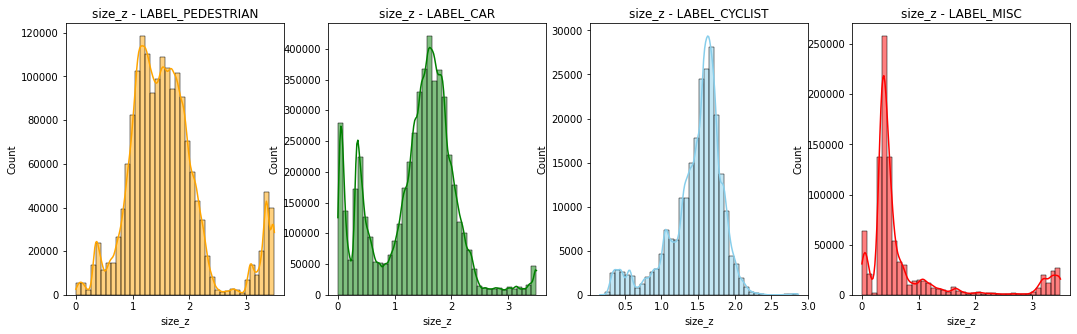

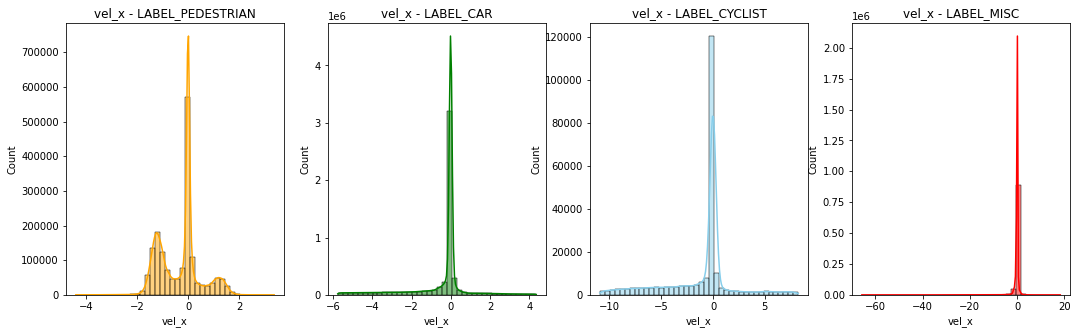

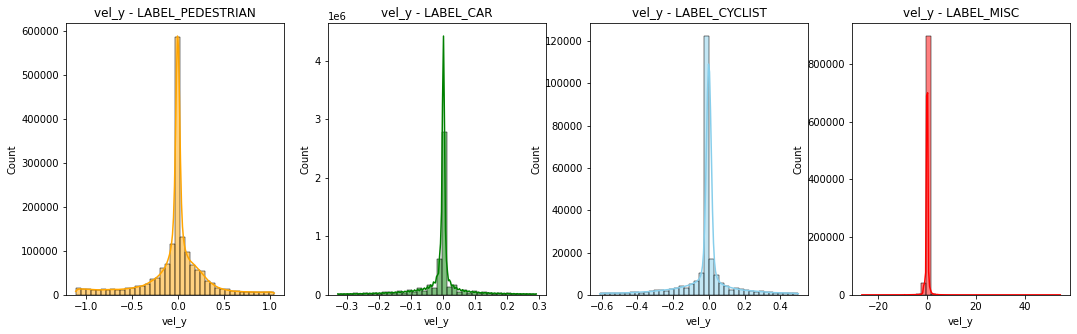

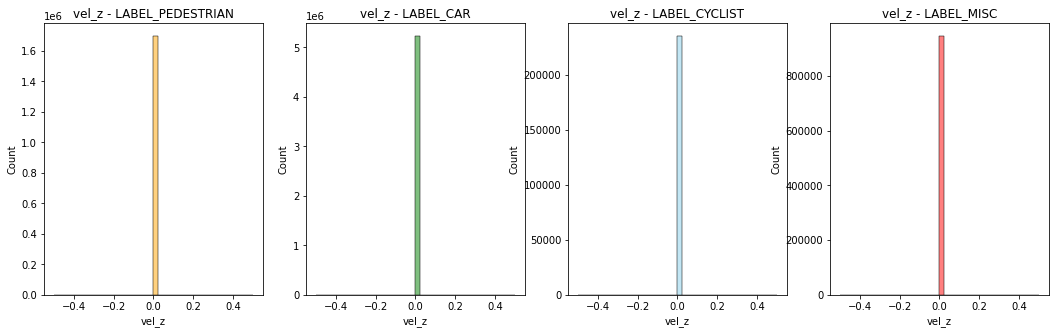

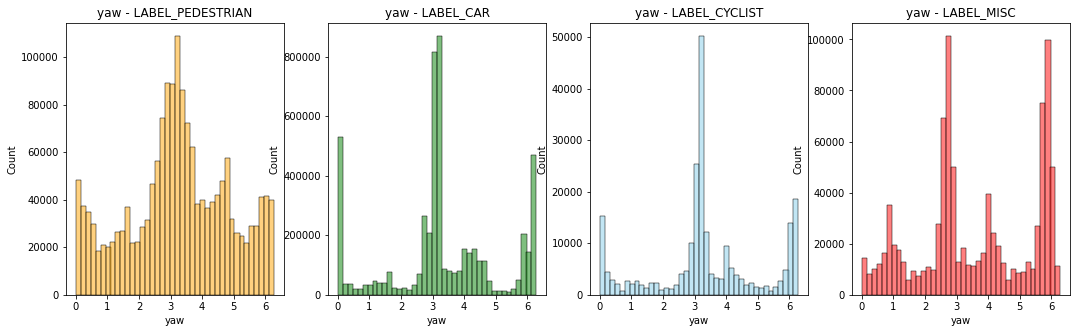

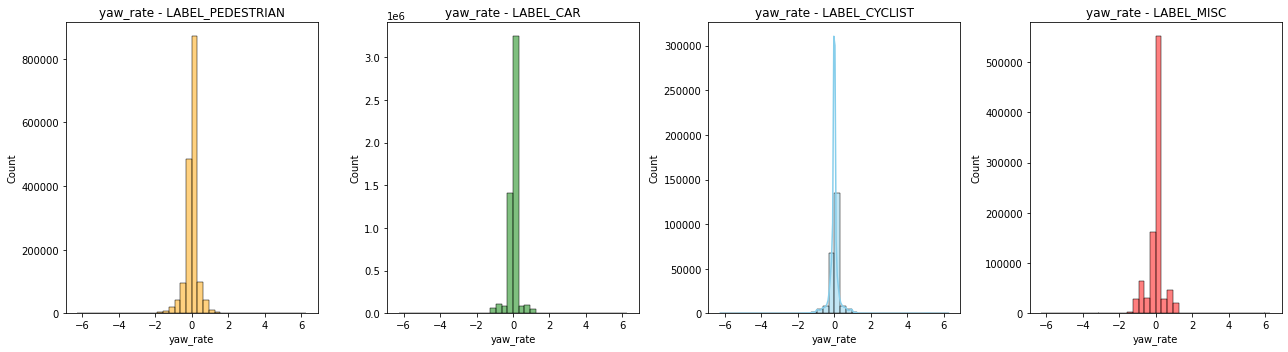

In [9]:
def replace_outliers(data_object,variables_to_handle):
    for col in variables_to_handle:
        Q1 = data_object[col].quantile(0.25)
        Q3 = data_object[col].quantile(0.75)
        IQR = Q3 - Q1
        coefficient = 3
        lower_bound = Q1-coefficient*IQR
        upper_bound = Q3+coefficient*IQR
        median_value = data_object[col].median()
        data_object.loc[:,col] = data_object.loc[:,col].apply(lambda x: median_value 
                                                  if x < lower_bound or x > upper_bound else x)
    return data_object

data["confidence"] = data["confidence"].clip(lower= 0, upper=1) # cap confidence level to 1
data["pos_z"] = 0 # set pos_z to 0
data["vel_z"] = 0 # set vel_z to 0

data_misc = data[data["label"] == "LABEL_MISC"]
data_pred = data[data["label"] == "LABEL_PEDESTRIAN"]
data_car = data[data["label"] == "LABEL_CAR"]
data_cyclist = data[data["label"] == "LABEL_CYCLIST"]

variables_to_handle = ["size_x","size_y","size_z","vel_x","vel_y"]

list_data_objects = []
for data_object in [data_pred,data_car, data_cyclist]:
    list_data_objects.append(replace_outliers(data_object,variables_to_handle))
list_data_objects.append(data_misc)

data = pd.concat(list_data_objects).reset_index(drop=True)
plot_histograms(data,numerical_columns)

In [10]:
#z = data[data["label"] != "LABEL_MISC"].groupby('id')['label'].value_counts(normalize=True).index
#zz = pd.DataFrame(z.values.tolist(),
#                                 columns=["id","label"])["label"].value_counts(normalize=True)*100
#display(zz)

### Building the model
In order to estimate the label, we will construct a classifier (*RandomForestClassifier*) that predicts whether it is a car, pedestrian or cyclist based on the *size*, *velocity* and *points_n* of the object.

When building the model we should take into consideration that the dataset is highly imbalanced, (**among non miscellaneous** objects 70% of objects are cars, 26% are pedestrian and 4% are cyclists). To that end, we set the **class_weight parameter to "balanced"** in random forest classifier and we use **stratified kfold validation** in order to respect target distribution in each fold split.

AUC-ROC (macro average): 0.9947478893386852


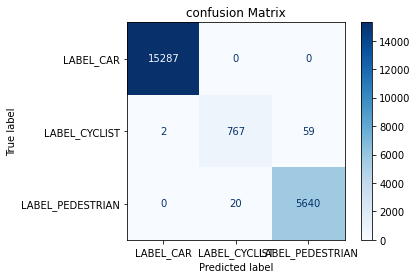

RandomForestClassifier(class_weight='balanced', n_estimators=10,
                       random_state=42)

In [11]:
features = ["size_x", "size_y", "size_z", "vel_x", "vel_y", "points_n"]
data_not_misc = data[data["label"] != "LABEL_MISC"]
grouped_data = data_not_misc.groupby("id")

# Select the mode of the label for each group
targets = [gp["label"].mode().values[0] for _, gp in grouped_data]
dataset = pd.concat(
    [pd.DataFrame(gp[features].mean(axis=0).values.reshape(1, -1)) for _, gp in grouped_data], 
    ignore_index=True)
dataset['target_label'] = targets

X = dataset.values[:,:6]  # selecting features (first 6 columns)
y = dataset['target_label']  

# encoding labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# we use class weight parameter and stratified_Kfold validation in order to handle imbalanced target labels
model = RandomForestClassifier(n_estimators=10, class_weight='balanced', random_state=42)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_prob = np.zeros((y_encoded.shape[0], len(np.unique(y_encoded))))
for train_idx, test_idx in stratified_kfold.split(X, y_encoded):
    model.fit(X[train_idx], y_encoded[train_idx])
    y_prob[test_idx] = model.predict_proba(X[test_idx])


auc_roc = roc_auc_score(y_encoded, y_prob, multi_class='ovo', average='weighted')
print("AUC-ROC (macro average): {auc_roc}".format(auc_roc=auc_roc))
y_pred = cross_val_predict(model, X, y_encoded, cv=stratified_kfold)

cm = confusion_matrix(y_encoded, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
cm_display.plot(cmap=plt.cm.Blues)
plt.title("confusion Matrix")
plt.show()

# retraining on full dataset to be used for prediction
model.fit(X, y)

In [12]:
cm

array([[15287,     0,     0],
       [    2,   767,    59],
       [    0,    20,  5640]])

### Applying the model to estimate miscellaneous labels

LABEL_CAR          0.60737
LABEL_PEDESTRIAN   0.34771
LABEL_CYCLIST      0.04492
Name: label, dtype: float64

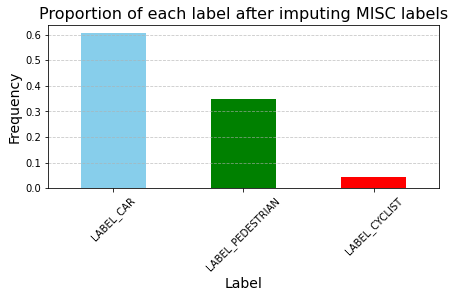

LABEL_PEDESTRIAN    3110
LABEL_CYCLIST        305
LABEL_CAR             32
Name: label, dtype: int64

In [13]:
# applying the model on objects whose label is MISC
data_misc = data[data["label"] == "LABEL_MISC"]
data_not_misc = data[data["label"] != "LABEL_MISC"]
grouped_data = data_misc.groupby("id")

dataset_misc = [(id_, gp[features].mean(axis=0).values.reshape(1, -1)) for id_, gp in grouped_data]
list_predictions_misc = [(id_, model.predict(feature_vector)[0]) for id_,feature_vector in dataset_misc]
df_predictions_misc = pd.DataFrame(list_predictions_misc,columns=["id","label"])

id_to_label = df_predictions_misc.set_index("id")["label"]
data["label"] = data["id"].map(id_to_label).combine_first(data["label"])

# computing relative frequency of each possible value for label after dealing with misc values
label_proportions = data.groupby('id')['label'].value_counts(normalize=True).index    
label_proportions = pd.DataFrame(label_proportions.values.tolist(),
                                 columns=["id","label"])["label"].value_counts(normalize=True)    
display(label_proportions)

# creating barcharts for label after imputing misc labels
fig, axes = plt.subplots(figsize=(7, 3), sharey=True)
label_proportions.plot(kind='bar', color=['skyblue',  'green', 'red'], ax=axes)
axes.set_title('Proportion of each label after imputing MISC labels', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Frequency', fontsize=14)
axes.tick_params(axis='x', rotation=45)
axes.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
display(df_predictions_misc["label"].value_counts())

### Insights on predictions
**Among 3447 miscellaneous objects, the model predicted 3110 (90%) as pedestrians, 305 as cyclists (8%) and 32 (2%) as cars.**